In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers, mixed_precision, regularizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-10-30 17:49:42.838005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 17:49:42.868443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 17:49:42.877826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 17:49:42.901403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = [f"R_{i}" for i in range(100)]

# Define file directory and load data
dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

# Prepare X, Y, Z based on loaded data
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]
Z = np.array(data['R_max']).reshape(-1, 1)  # Shape Z as (nrows, 1)

# Transpose X and Y to shape (nrows, ncols)
X, Y = X.T, Y.T

# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))  # Shared scaler for Y and Z

# Fit-transform X
x = scaler_X.fit_transform(X)

# Mask and scale non-zero values in Y
nz = Y != 0
y = np.copy(Y)  # Copy Y to keep zeros intact
y[nz] = scaler_Y.fit_transform(Y[nz].reshape(-1, 1)).flatten() 

# Scale Z with the same scaler as Y
z = scaler_Y.transform(Z)

# Split the data for training and validation as required
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

y_tr2, y_ts2, z_tr, z_ts = train_test_split(y, z, test_size=0.2, random_state=42)
y_ts2, y_vl, z_ts, z_vl = train_test_split(y_ts2, z_ts, test_size=0.01, random_state=42)

In [19]:
# Load model from file
#model = tf.keras.models.load_model("../../models/model_nl.keras")

model1 = tf.keras.models.Sequential([
    layers.Dense(y_ncols, activation='relu', input_shape=(x_ncols,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(224, activation='relu'),
    layers.Dense(y_ncols, activation='sigmoid')
])
model1.compile(optimizer='adam', loss='mse', metrics=['mae'])
model1.summary()
batch_size = 128
num_epochs = 1000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6
)

/home/anik/mconda/envs/tfg/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 100)            │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │        51,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 224)            │       114,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        22,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,124 (742.67 KB)

 Trainable params: 190,124 (742.67 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
training1 = model1.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early, lr_schedule], verbose=2)

Epoch 1/1000


67/67 - 8s - 116ms/step - loss: 0.0214 - mae: 0.0979 - val_loss: 0.0027 - val_mae: 0.0380 - learning_rate: 0.0010
Epoch 2/1000
67/67 - 0s - 1ms/step - loss: 0.0023 - mae: 0.0323 - val_loss: 0.0018 - val_mae: 0.0274 - learning_rate: 0.0010
Epoch 3/1000
67/67 - 0s - 2ms/step - loss: 0.0015 - mae: 0.0236 - val_loss: 0.0013 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 4/1000
67/67 - 0s - 2ms/step - loss: 0.0011 - mae: 0.0185 - val_loss: 9.6287e-04 - val_mae: 0.0165 - learning_rate: 0.0010
Epoch 5/1000
67/67 - 0s - 2ms/step - loss: 8.3179e-04 - mae: 0.0148 - val_loss: 7.2982e-04 - val_mae: 0.0132 - learning_rate: 0.0010
Epoch 6/1000
67/67 - 0s - 3ms/step - loss: 6.6573e-04 - mae: 0.0123 - val_loss: 6.2103e-04 - val_mae: 0.0115 - learning_rate: 0.0010
Epoch 7/1000
67/67 - 0s - 3ms/step - loss: 5.7193e-04 - mae: 0.0111 - val_loss: 5.4243e-04 - val_mae: 0.0107 - learning_rate: 0.0010
Epoch 8/1000
67/67 - 0s - 3ms/step - loss: 4.8921e-04 - mae: 0.0102 - val_loss: 4.6644e-04 - val_mae: 0.0102

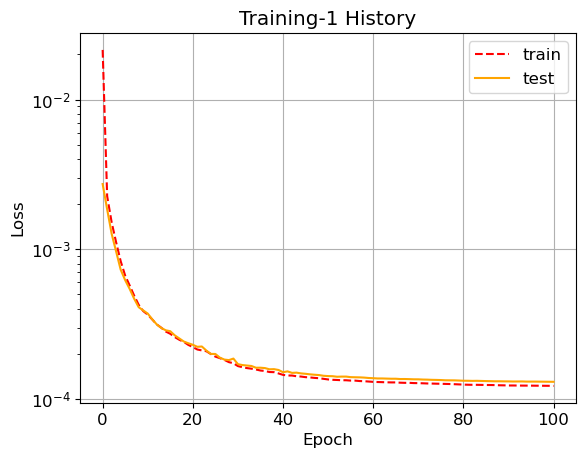

In [21]:
plt.semilogy(training1.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training1.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training-1 History")
plt.legend()
plt.show()

In [22]:
model2 = tf.keras.models.Sequential([
    layers.Dense(1, activation='linear', input_shape=(y_ncols,))
])

model2.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=['mae']
)
model2.summary()

batch_size = 128
num_epochs = 1000

# Set up a callback to stop early if given criteria is satisfied
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
training2 = model2.fit(x=y_tr2, y=z_tr, batch_size=batch_size, validation_data=(y_ts2, z_ts), \
                    epochs=num_epochs, callbacks=[early_stop, lr_schedule], verbose=2)

Epoch 1/1000
67/67 - 2s - 26ms/step - loss: 0.0052 - mae: 0.0551 - val_loss: 0.0024 - val_mae: 0.0394 - learning_rate: 0.0010
Epoch 2/1000
67/67 - 0s - 2ms/step - loss: 0.0023 - mae: 0.0389 - val_loss: 0.0022 - val_mae: 0.0374 - learning_rate: 0.0010
Epoch 3/1000
67/67 - 0s - 2ms/step - loss: 0.0021 - mae: 0.0372 - val_loss: 0.0020 - val_mae: 0.0357 - learning_rate: 0.0010
Epoch 4/1000
67/67 - 0s - 2ms/step - loss: 0.0020 - mae: 0.0358 - val_loss: 0.0019 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 5/1000
67/67 - 0s - 2ms/step - loss: 0.0019 - mae: 0.0348 - val_loss: 0.0018 - val_mae: 0.0338 - learning_rate: 0.0010
Epoch 6/1000
67/67 - 0s - 2ms/step - loss: 0.0018 - mae: 0.0338 - val_loss: 0.0017 - val_mae: 0.0327 - learning_rate: 0.0010
Epoch 7/1000
67/67 - 0s - 2ms/step - loss: 0.0017 - mae: 0.0329 - val_loss: 0.0016 - val_mae: 0.0319 - learning_rate: 0.0010
Epoch 8/1000
67/67 - 0s - 2ms/step - loss: 0.0016 - mae: 0.0320 - val_loss: 0.0015 - val_mae: 0.0311 - learning_rate: 0.0010

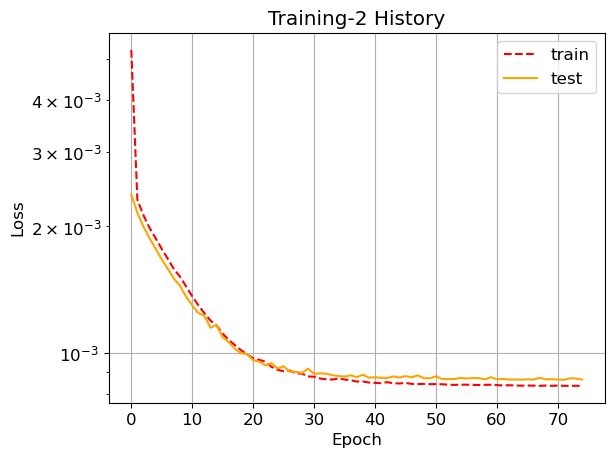

In [24]:
plt.semilogy(training2.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training2.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training-2 History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


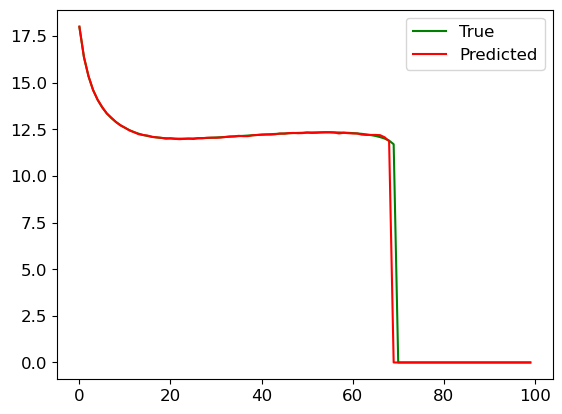

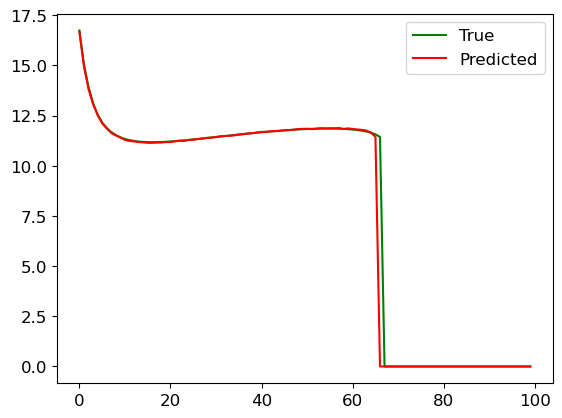

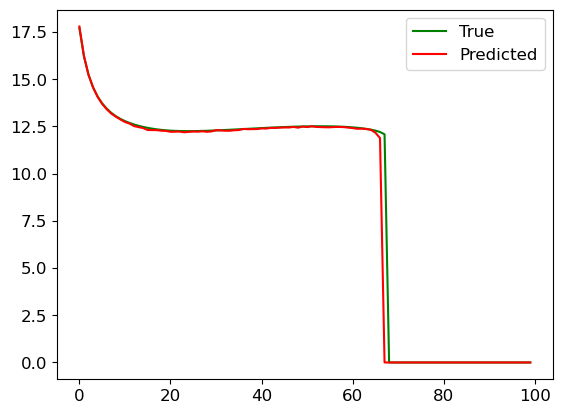

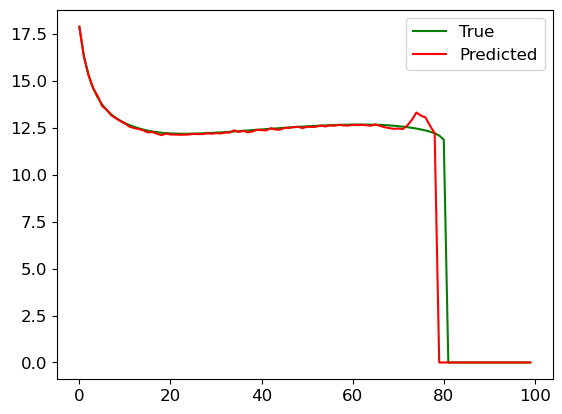

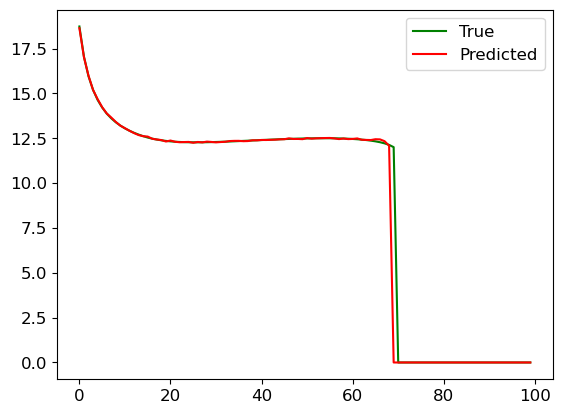

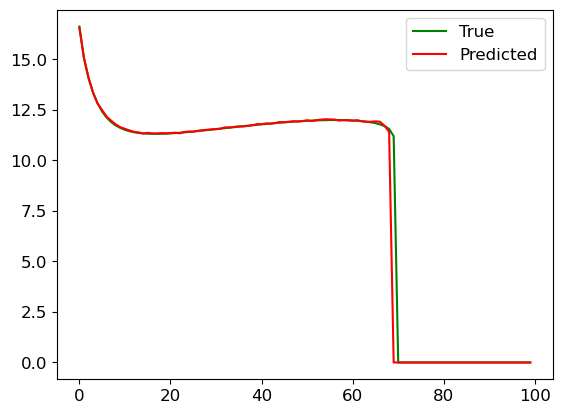

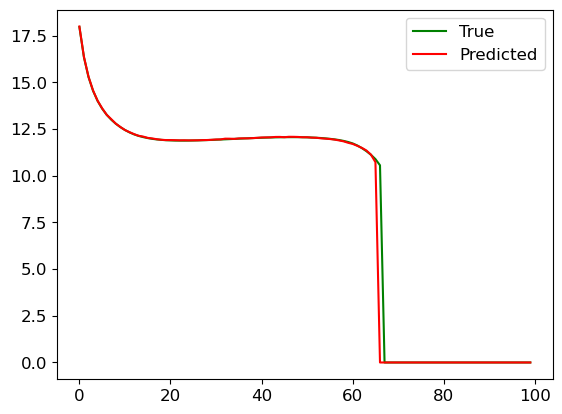

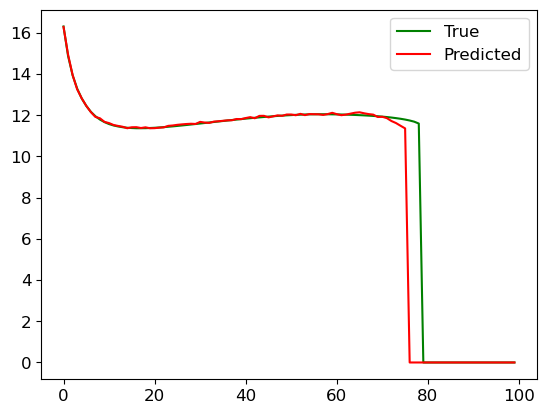

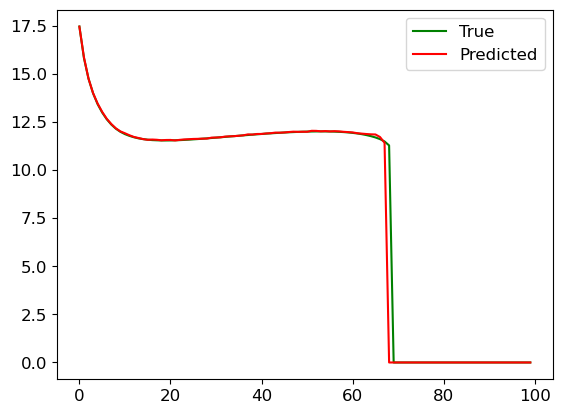

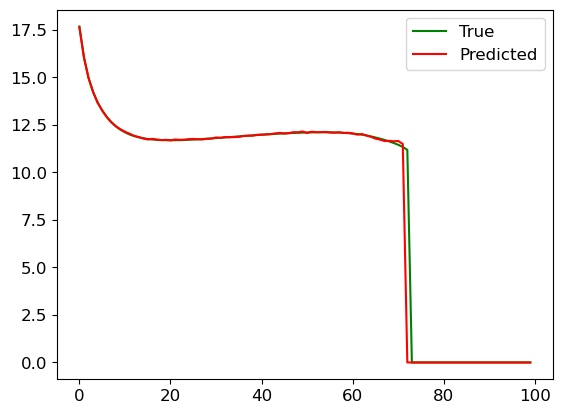

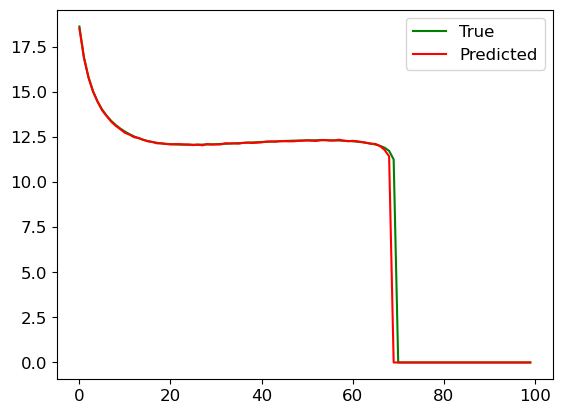

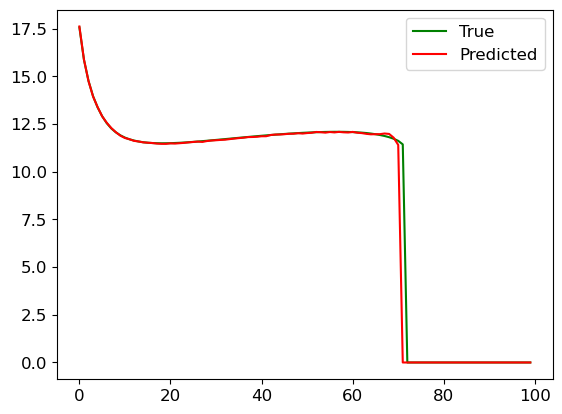

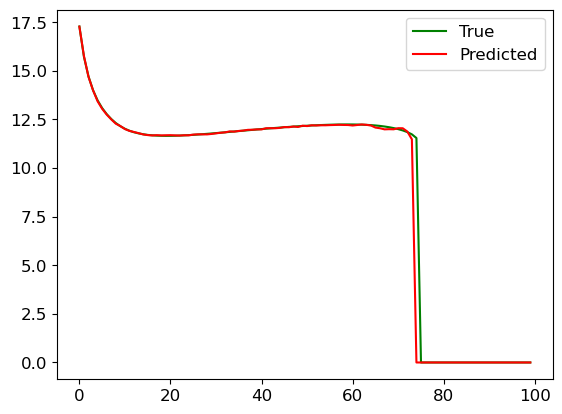

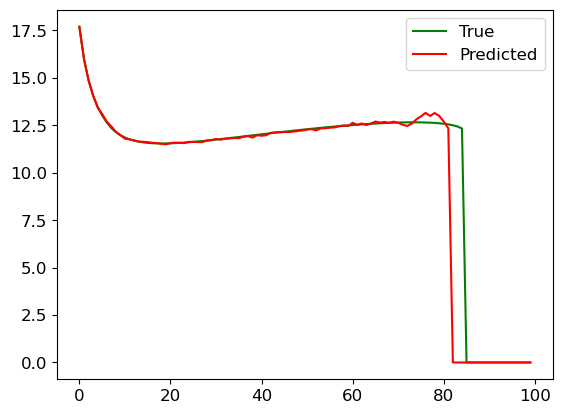

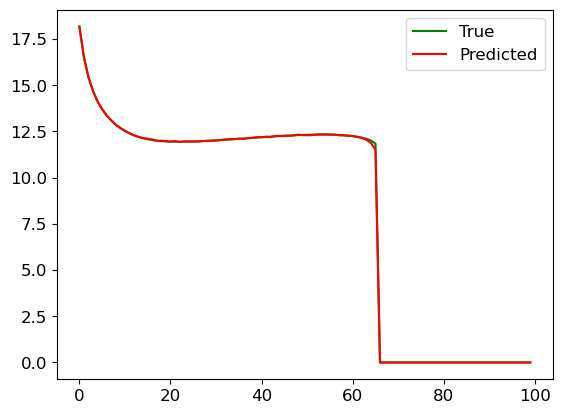

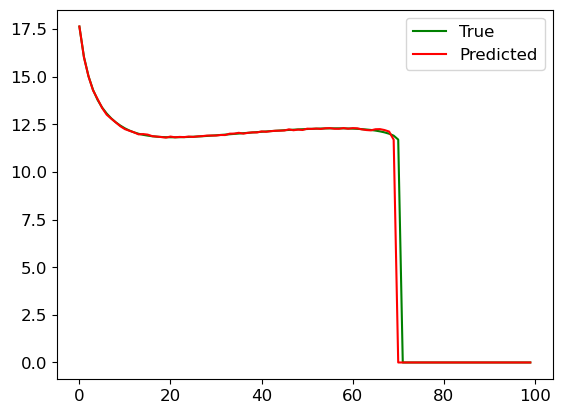

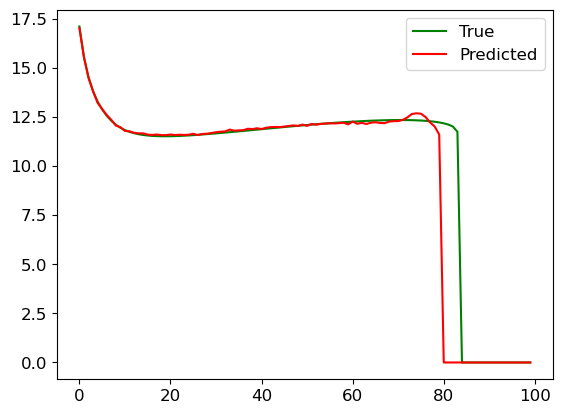

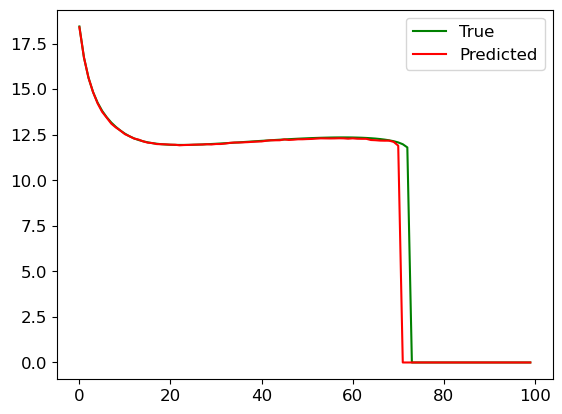

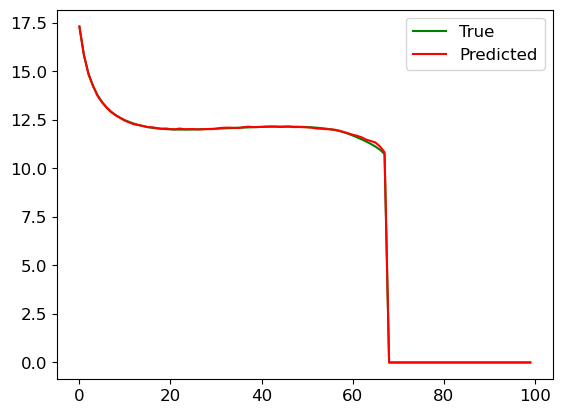

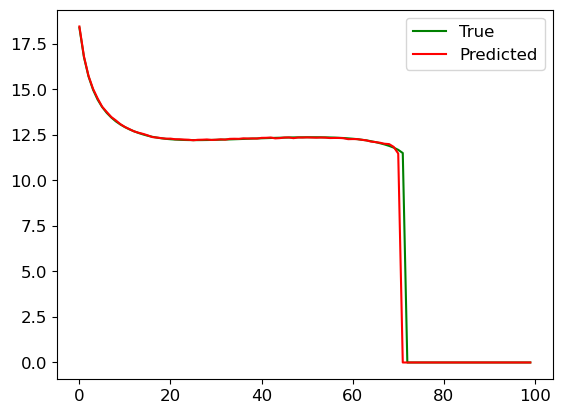

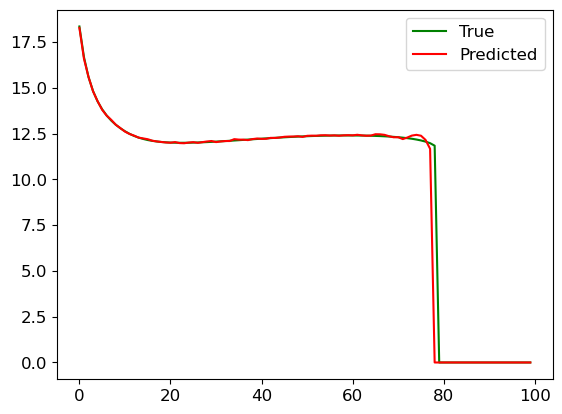

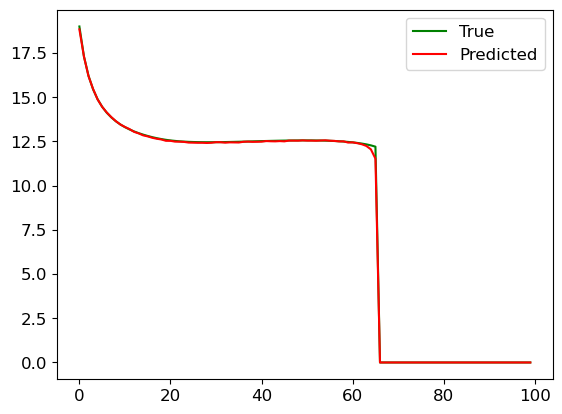

In [25]:
y_pr = model1.predict(x_vl)
z_pr = model2.predict(y_pr)

# Post-processing loop to zero values in y_pr based on z_pr, starting from the last element
for i in range(len(y_pr)):
    for j in range(len(y_pr[i]) - 1, -1, -1):  # Start from the last element in y_pr[i]
        v = y_pr[i][j]
        if v > z_pr[i]:  # Stop setting to zero once v > z_pr[i]
            break
        y_pr[i][j] = 0  # Set values to zero

nz_pr = y_pr != 0
nz_vl = y_vl != 0

Y_pr = np.copy(y_pr)
Y_vl = np.copy(y_vl)

Y_pr[nz_pr] = scaler_Y.inverse_transform(y_pr[nz_pr].reshape(-1, 1)).flatten()
Y_vl[nz_vl] = scaler_Y.inverse_transform(y_vl[nz_vl].reshape(-1, 1)).flatten()

for i in range(y_pr.shape[0]):
    plt.plot(Y_vl[i], label='True', c='green')
    plt.plot(Y_pr[i], label='Predicted', c='red')
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


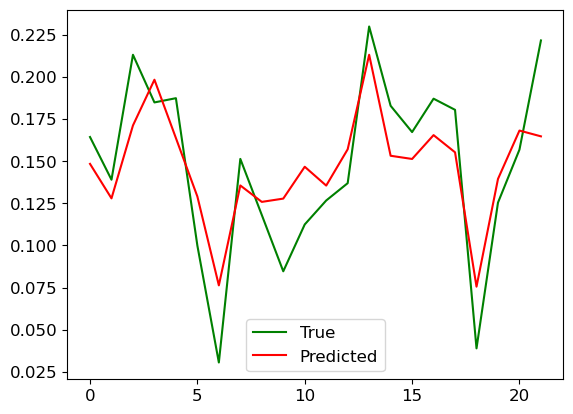

In [26]:
y_pr = model1.predict(x_vl)
z_pr = model2.predict(y_pr)
plt.plot(z_vl, label='True', c='green')
plt.plot(z_pr, label='Predicted', c='red')
plt.legend()
plt.show()